In [1]:
import sys
sys.version

'3.10.12 (main, Nov 20 2023, 15:14:05) [GCC 11.4.0]'

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
pip install attention

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [5]:
import pywt
import tensorflow as tf

In [6]:
import numpy as np
import os
import re
import scipy.io as scio

import numpy as np
import pandas as pd
import scipy.signal
from keras.models import Sequential,Model,load_model
from keras.optimizers import Adam
from sklearn.preprocessing import LabelBinarizer
from sklearn import preprocessing
from keras.layers import *
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import itertools
from sklearn.metrics import confusion_matrix
from keras.callbacks import ReduceLROnPlateau
from keras import backend as k
from keras.callbacks import ModelCheckpoint

In [7]:
def Sliding_Window(df_temp, win_len, stride):
    """
    Sliding window function for data segmentation and label extraction.

    Args:
        df_temp (DataFrame): Input dataframe containing the data.
        win_len (int): Length of the sliding window.
        stride (int): Stride or step size for sliding the window.

    Returns:
        X (ndarray): Segmented input sequences.
        Y (ndarray): Extracted output labels.
        T (ndarray): Corresponding timestamps.
    """
    X = []  # List to store segmented input sequences.
    Y = []  # List to store extracted output labels.
    T = []  # List to store corresponding timestamps.

    # Loop through the dataframe with the specified stride.
    for i in np.arange(0, len(df_temp) - win_len, stride):
        # Extract a subset of the dataframe based on the window length.
        temp = df_temp.iloc[i:i + win_len, [3, 4]].values

        # Append the segmented input sequence to the X list.
        X.append(temp)

        # Append the output label at the end of the window to the Y list.
        Y.append(df_temp.iloc[i + win_len, -1])

        # Append the timestamp at the end of the window to the T list.
        T.append(df_temp.iloc[i + win_len, 0])

    return np.array(X), np.array(Y), np.array(T)

- The data imported from the Matlab-simulink model are in **csv format**, with name as "{Fault}_noise_02.csv"
- **M** number of such files are present, coresponding to **M** faults.
- In each fault file, the fault is introduced at **t=\[1000,1500\]s** for incipient fault and **t=\[2000,2500\]s** for the step fault.

The Goal is to extract only the values of residuals between t=\[1000,1500\]s and t=\[2000,2500\]s. These values are then stored in a **new DataFrame**, which contains the residual information for all the fault classes.

In [8]:
def PreprocessData(working_cond, win_len, stride):
    """
    Preprocessing function to extract input sequences and output labels from CSV files of a specific working condition.

    Args:
        working_cond (str): Working condition identifier used to locate the folder containing CSV files.
        win_len (int): Length of the sliding window.
        stride (int): Stride or step size for sliding the window.

    Returns:
        X_full (ndarray): Concatenated segmented input sequences.
        Y_full (ndarray): Concatenated output labels.
    """
    Path = r'.\ALL_DC_motor_Data\Ua_{}V_Noise_2_perct'.format(working_cond)  # Path of the folder containing CSV files from that working condition
    Path = r'/content/drive/MyDrive/ALL_DC_motor_Data/Ua_{}V_Noise_2_perct'.format(working_cond)
    # Path = r'.\content\ALL_DC_motor_Data\Ua_{}V_Noise_2_perct'.format(working_cond)
    file_name = os.listdir(path=Path)

    X_full, Y_full = [], []  # Lists to store concatenated segmented input sequences and output labels

    for f in file_name:  # Iterate through each file, which corresponds to a fault
        csv_path = os.path.join(Path, f)
        df = pd.read_csv(csv_path)

        temp_df_1 = df[(df.time > 1050) & (df.time < 1500)]  # Incipient - Taking samples after which the parameter fault was introduced
        x1, y1, _ = Sliding_Window(temp_df_1, win_len, stride)

        temp_df_2 = df[(df.time > 2050) & (df.time < 2500)]  # Step - Taking samples after which the parameter fault was introduced
        x2, y2, _ = Sliding_Window(temp_df_2, win_len, stride)

        x_temp, y_temp = np.concatenate((x1, x2), axis=0), np.concatenate((y1, y2), axis=0)

        X_full.append(x_temp)
        Y_full.append(y_temp)

    X_full = np.array(X_full)
    X_full = np.reshape(X_full, (-1, X_full.shape[2], X_full.shape[3]))

    Y_full = np.array(Y_full)
    Y_full = np.reshape(Y_full, (-1))

    return X_full, Y_full


In [9]:
WL=20
S=40

# Preprocess data for working condition 120
X_120, Y_120 = PreprocessData(working_cond=120, win_len=WL, stride=S)

# Preprocess data for working condition 80
X_80, Y_80 = PreprocessData(working_cond=80, win_len=WL, stride=S)

# Preprocess data for working condition 40
X_40, Y_40 = PreprocessData(working_cond=40, win_len=WL, stride=S)

In [10]:
# Concatenate the preprocessed data from different working conditions
X_full = np.concatenate((X_40, X_80, X_120))
Y_full = np.concatenate((Y_40, Y_80, Y_120))

# Print the length of the total data
print(f"Length of total data = {len(X_full)}")

Length of total data = 5376


In [11]:
# raw_data = X_full.reshape(40)
# raw_data.shape

In [12]:
# wavelet_data = np.repeat(np.nan, repeats = 672 * 8 * 20 * 2).reshape(-1, 20, 2)
# for i in range(raw_data.shape[0]):
#     segment = raw_data[i, :]
#     coefs, _ = pywt.cwt(segment, np.arange(start = 1, stop = 2049, step = 32), "morl")
#     wavelet_data[i, :, :] = tf.reshape(tf.image.resize(coefs.reshape((64, 40, 1)), (20, 2)), (20, 2))
#     if (i % 100) == 0 and (i != 0):
#         print(f"{i} segments processed.")

In [13]:
# Train Test split
X_train, X_test, y_train, y_test = train_test_split(X_full, Y_full, train_size=19, random_state=42)

# Standardising the data
scaler = StandardScaler()
X_train_sc = scaler.fit_transform(X_train.reshape(-1,X_train.shape[-1])).reshape(X_train.shape)
X_test_sc = scaler.transform(X_test.reshape(-1,X_test.shape[-1])).reshape(X_test.shape)
# One Hot encoding
encoder = OneHotEncoder(sparse_output=False)
# encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
y_train_ohe = encoder.fit_transform(y_train.reshape(-1,1))
y_test_ohe = encoder.transform(y_test.reshape(-1,1))

In [14]:
# print(X_test.shape)

In [15]:
# print(wavelet_data.shape)

# CNN Model

In [16]:
def CNN_model(encoder,X_train_transformed):
    from tensorflow.keras.models import Sequential,Model
    from tensorflow.keras.layers import Input,Dense, Dropout, Flatten
    from tensorflow.keras.layers import Conv1D, MaxPooling1D
    from attention import Attention

    num_classes=len(encoder.categories_[0])

    cnn_model = Sequential()
    cnn_model.add(Conv1D(16, kernel_size=(5),activation='relu',input_shape=(X_train_transformed.shape[1],X_train_transformed.shape[2]),padding='same'))
    cnn_model.add(MaxPooling1D((2),padding='same'))
    # cnn_model.add(Flatten())
    # cnn_model.add(LSTM(60))
    # cnn_model.add(LSTM(60, return_sequences=True))
    # cnn_model.add(LSTM(60, return_sequences=True))
    # cnn_model.add(Dropout(0.5))
    # cnn_model.add(Attention()),
    # cnn_model.add(Dense(10, activation='softmax'))
    # cnn_model.add(Dense(128, activation='relu'))
    cnn_model.add(LSTM(112, return_sequences=True))
    cnn_model.add(Dropout(0.2))
    cnn_model.add(LSTM(16,return_sequences=True))
    cnn_model.add(LSTM(48,return_sequences=True))
    cnn_model.add(Dropout(0.5))
    cnn_model.add(Attention())
    cnn_model.add(Flatten())
    cnn_model.add(Dense(64, activation='relu'))
    cnn_model.add(Dense(num_classes, activation='softmax'))

    cnn_model.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate=0.001),metrics=['accuracy'])

    return cnn_model

# AI Training

In [17]:
from sklearn.metrics import f1_score
import tensorflow

# Define an EarlyStopping callback to monitor validation accuracy and restore best weights
callback = tensorflow.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=10, restore_best_weights=True)

# Create a CNN model using the specified encoder and X_train_sc
cnn_model = CNN_model(encoder, X_train_sc)

# Train the CNN model
cnn_model.fit(X_train_sc,
              y_train_ohe,
              epochs=200,
              batch_size=16,
              validation_data=(X_test_sc, y_test_ohe),
              callbacks=[callback],
              shuffle=False,
              verbose=1)

Epoch 1/200
2/2 [==============================] - 14s 3s/step - loss: 2.0764 - accuracy: 0.1579 - val_loss: 2.0673 - val_accuracy: 0.4407
Epoch 2/200
2/2 [==============================] - 2s 2s/step - loss: 2.0606 - accuracy: 0.3158 - val_loss: 2.0579 - val_accuracy: 0.3948
Epoch 3/200
2/2 [==============================] - 2s 2s/step - loss: 2.0319 - accuracy: 0.4737 - val_loss: 2.0485 - val_accuracy: 0.3885
Epoch 4/200
2/2 [==============================] - 2s 2s/step - loss: 2.0020 - accuracy: 0.6316 - val_loss: 2.0366 - val_accuracy: 0.3819
Epoch 5/200
2/2 [==============================] - 3s 3s/step - loss: 1.9512 - accuracy: 0.4737 - val_loss: 2.0243 - val_accuracy: 0.3515
Epoch 6/200
2/2 [==============================] - 3s 3s/step - loss: 1.8897 - accuracy: 0.5263 - val_loss: 2.0132 - val_accuracy: 0.3401
Epoch 7/200
2/2 [==============================] - 2s 2s/step - loss: 1.8345 - accuracy: 0.4737 - val_loss: 2.0093 - val_accuracy: 0.3074
Epoch 8/200
2/2 [================

In [18]:
# history = cnn_model.history

# # Extract training loss and validation loss
# training_loss = history.history['loss']
# validation_loss = history.history['val_loss']

# import matplotlib.pyplot as plt

# # Example data (replace with your actual data)
# epochs = []
# for i in range(1,32):
#   epochs.append(i)

# # Plot training loss and validation loss
# plt.figure(figsize=(8, 6))
# plt.plot(epochs, training_loss, label="Training Loss", marker='o')
# plt.plot(epochs, validation_loss, label="Validation Loss", marker='x')
# plt.xlabel("Number of Epochs")
# plt.ylabel("Loss")
# plt.title("Training Loss and Validation Loss vs Number of Epochs")
# plt.legend()
# # plt.grid(True)
# plt.show()

In [19]:
cnn_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 20, 16)            176       
                                                                 
 max_pooling1d (MaxPooling1  (None, 10, 16)            0         
 D)                                                              
                                                                 
 lstm (LSTM)                 (None, 10, 112)           57792     
                                                                 
 dropout (Dropout)           (None, 10, 112)           0         
                                                                 
 lstm_1 (LSTM)               (None, 10, 16)            8256      
                                                                 
 lstm_2 (LSTM)               (None, 10, 48)            12480     
                                                        

In [20]:
# Perform prediction using the CNN model on the scaled test data
y_pred = cnn_model.predict(X_test_sc)

# Inverse transform the predicted labels using the encoder
y_pred = encoder.inverse_transform(y_pred)

# Calculate and print the F1 score
f1score = f1_score(y_test, y_pred, average='weighted')
print(f"Train Sample = {len(X_train)}, The F1 score is - {f1score}")


168/168 [==============================] - 3s 7ms/step
Train Sample = 19, The F1 score is - 0.3756898720343149


In [21]:
y_pred

array([['Re'],
       ['Re'],
       ['Re'],
       ...,
       ['Re'],
       ['I'],
       ['Re']], dtype='<U7')

In [22]:
import numpy as np
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score

# Define the actual and predicted values as numpy arrays
actual_values = y_test
predicted_values = y_pred

# Compute precision, recall, and F1-score
precision = precision_score(actual_values, predicted_values, average='weighted')
recall = recall_score(actual_values, predicted_values, average='weighted')
f1 = f1_score(actual_values, predicted_values, average='weighted')
accuracy = accuracy_score(actual_values, predicted_values)

print(f"Weighted Precision: {precision:.4f}")
print(f"Weighted Recall: {recall:.4f}")
print(f"Weighted F1-score: {f1:.4f}")
print(f"Weighted Accuracy: {accuracy:.4f}")

Weighted Precision: 0.3865
Weighted Recall: 0.4407
Weighted F1-score: 0.3757
Weighted Accuracy: 0.4407


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [23]:
y_pred[1]

array(['Re'], dtype='<U7')

In [24]:
for i in range(len(y_pred)):
  if y_pred[i]=='Re':
    y_pred[i]=1
  elif y_pred[i]=='Rm':
    y_pred[i]=2
  elif y_pred[i]=='I':
    y_pred[i]=3
  elif y_pred[i]=='W':
    y_pred[i]=4
  elif y_pred[i]=='K':
    y_pred[i]=5
  elif y_pred[i]=='I & W':
    y_pred[i]=7
  elif y_pred[i]=='Re & Rm':
    y_pred[i]=6
  else:
    y_pred[i]=0

In [25]:
y_pred[1]

array(['1'], dtype='<U7')

In [26]:
print('0' in y_test)

False


In [27]:
test = []
for i in range(len(y_test)):
  if y_test[i]=='0':
    test.append('-1')
  else:
    test.append(y_test[i])
pred = []
for i in range(len(y_test)):
  if y_pred[i]=='0':
    pred.append('-1')
  else:
    pred.append(y_test[i])

In [28]:
y_pred

array([['1'],
       ['1'],
       ['1'],
       ...,
       ['1'],
       ['3'],
       ['1']], dtype='<U7')

In [29]:
print(['0'] in y_pred)

False


In [30]:
print(recall_score(y_test, y_pred, average='weighted', zero_division = 1))
print(precision_score(test, pred, average='weighted'))
print(f1_score(test, pred, average='weighted'))
print(accuracy_score(test, pred))

0.0
1.0
1.0
1.0


In [31]:
ct = 0
for i in range(len(y_test)):
  if y_test[i]==y_pred[i]:
    ct+=1
print(ct/len(y_test))

0.0


In [32]:
for i in range(len(y_test)):
  if y_test[i]=='Re':
    y_test[i]=1
  elif y_test[i]=='Rm':
    y_test[i]=2
  elif y_test[i]=='I':
    y_test[i]=3
  elif y_test[i]=='W':
    y_test[i]=4
  elif y_test[i]=='K':
    y_test[i]=5
  elif y_test[i]=='I & W':
    y_test[i]=7
  elif y_test[i]=='Re & Rm':
    y_test[i]=6
  else:
    y_test[i]=0

In [33]:
y_pred
pred = []
for i in y_pred:
  pred.append(i[0])
pred = np.array(pred)
pred

array(['1', '1', '1', ..., '1', '3', '1'], dtype='<U1')

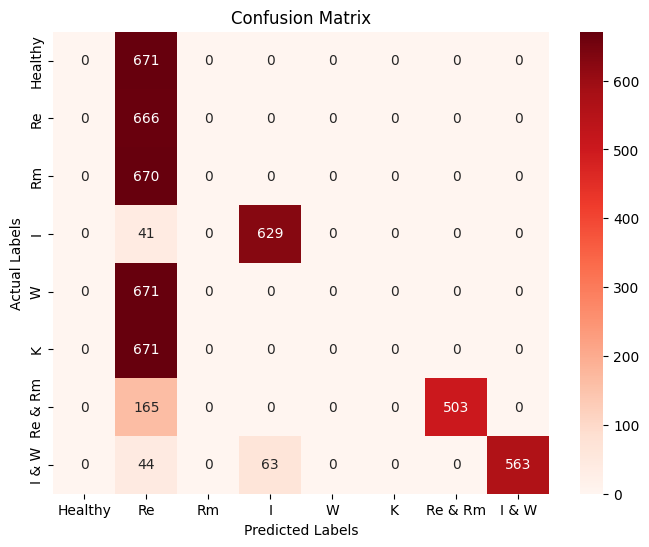

In [34]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Define the class labels
class_labels = ['Healthy', 'Re', 'Rm', 'I', 'W', 'K', 'Re & Rm', 'I & W']

# Define the actual and predicted values as numpy arrays
# actual_values = np.array([0, 3, 7, 5, 1, 6, 2, 4])
# predicted_values = np.array([0, 3, 7, 5, 1, 6, 2, 4])

# Create the confusion matrix
conf_matrix = confusion_matrix(y_test, pred)

# Create a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, cmap='Reds', fmt='d', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel("Predicted Labels")
plt.ylabel("Actual Labels")
plt.title("Confusion Matrix")
plt.show()


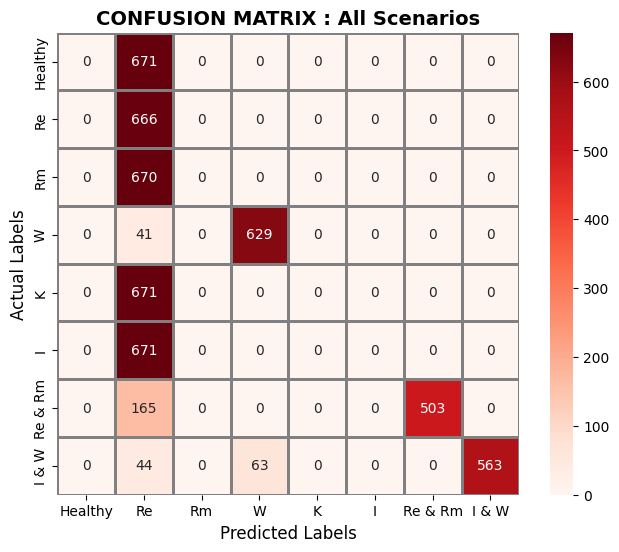

In [35]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Define the class labels
class_labels = ['Healthy', 'Re', 'Rm', 'W', 'K', 'I', 'Re & Rm', 'I & W']

# Define the actual and predicted values as numpy arrays
actual_values = np.array([0, 3, 7, 5, 1, 6, 2, 4])
predicted_values = np.array([0, 3, 7, 5, 1, 6, 2, 4])

# Create the confusion matrix
conf_matrix = confusion_matrix(y_test, pred)

# Create a heatmap with boxed class labels
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, cmap='Reds', fmt='d', xticklabels=class_labels, yticklabels=class_labels, cbar=True,
            linewidths=1, linecolor='gray', square=True)
plt.xlabel("Predicted Labels", fontsize=12)
plt.ylabel("Actual Labels", fontsize=12)
plt.title("CONFUSION MATRIX : All Scenarios", fontsize=14, fontweight='bold')
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.show()


In [36]:
test = []
for i in range(670,1333):
  test.append(y_test[i])
for i in range(2662,3325):
  test.append(y_test[i])

# 608-1215
# 2432-3039

# 640-1279
# 2560-3199

# 656-1311
# 2624-3279

# 664-1327
# 2656-3319

# 668-1331
# 2660-3323


pred = []
for i in range(670,1333):
  pred.append(y_pred[i])
for i in range(2662,3325):
  pred.append(y_pred[i])

f1score = f1_score(test, pred, average='weighted')
print(f"Train Sample = {len(X_train)}, The F1 score is - {f1score}")

Train Sample = 19, The F1 score is - 0.3848101500692199


In [37]:
type(y_test[1])

numpy.str_

In [38]:
sit = ['1', '2', '3', '4', '5', '6', '7']
test_roc = []
pred_roc = []
for i in range(len(y_test)):
  if y_test[i] in sit:
    test_roc.append(1)
  else:
    test_roc.append(0)
for i in range(len(y_test)):
  if y_pred[i] in sit:
    pred_roc.append(1)
  else:
    pred_roc.append(0)

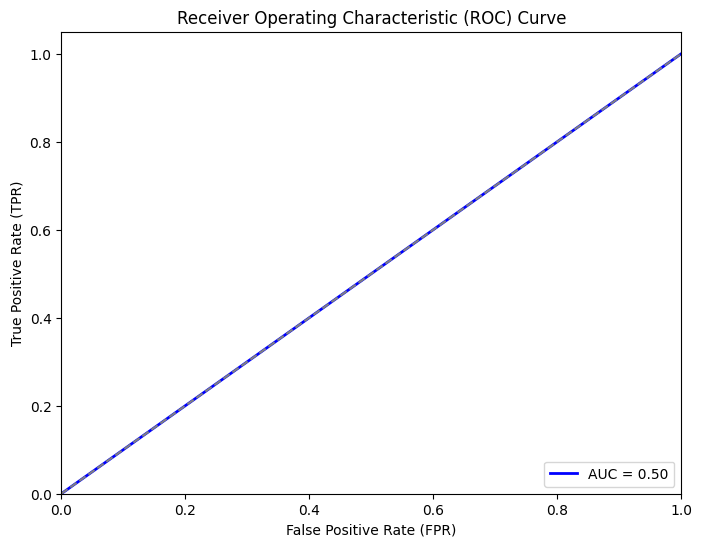

In [39]:
from sklearn.metrics import roc_curve, roc_auc_score, auc

# Example: Actual and predicted values (replace with your own data)
actual_values = test_roc
predicted_probs = pred_roc

# Compute ROC curve
fpr, tpr, threshold = roc_curve(actual_values, predicted_probs)

# Compute AUC (Area Under the Curve)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='b', lw=2, label=f"AUC = {roc_auc:.2f}")
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()


# Real Time Fault Diagnosis

In [40]:
# Dictionary mapping fault labels to their corresponding numeric values
fault_label_dict = {
    'Healthy': 0,
    'I': 3,
    'I & W': 7,
    'K': 5,
    'Re': 1,
    'Re & Rm': 6,
    'Rm': 2,
    'W': 4
}

In [41]:
'''fault_file = 'Healthy_noise_02.csv',
'I & W_noise_02.csv',
'I_noise_02.csv',
'K_noise_02.csv',
'Re & Rm_noise_02.csv',
'Re_noise_02.csv',
'Rm_noise_02.csv',
'W_noise_02.csv'''
def Predict_CNN(fault_file,working_cond, cnn_model, scaler, encoder, WL, S):
    """
    Predict fault labels using a trained CNN model.

    Args:
        fault_file (str): Name of the fault file to predict labels for.
        cnn_model (Model): Trained CNN model for fault prediction.
        scaler (Scaler): Scaler object for data normalization.
        encoder (Encoder): Encoder object for label encoding.
        WL (int): Length of the sliding window.
        S (int): Stride or step size for sliding the window.

    Returns:
        y_pred_num (ndarray): Predicted fault labels in numerical format.
        y_true_num (ndarray): True fault labels in numerical format.
        t1 (ndarray): Corresponding timestamps.
    """
    # Construct the path to the fault file
    # Path = r'.\ALL_DC_motor_Data\Ua_{}V_Noise_2_perct'.format(working_cond)  # Path of the folder containing CSV files from that working condition
    Path = r'/content/drive/MyDrive/ALL_DC_motor_Data/Ua_{}V_Noise_2_perct'.format(working_cond)
    csv_path = os.path.join(Path, fault_file)
    df = pd.read_csv(csv_path)

    # Perform sliding window operation on the data
    x1, y1, t1 = Sliding_Window(df, win_len=WL, stride=S)

    # Normalize the input data using the provided scaler
    x_sc = scaler.transform(x1.reshape(-1, x1.shape[-1])).reshape(x1.shape)

    # Make predictions using the CNN model
    y_pred = cnn_model.predict(x_sc)
    y_pred = encoder.inverse_transform(y_pred)

    # Convert the predicted labels to numerical format
    y_pred_num = np.vectorize(fault_label_dict.get)(y_pred)
    y_pred_num = y_pred_num.reshape(-1)

    # Convert the true labels to numerical format
    y_true_num = np.vectorize(fault_label_dict.get)(y1)
    y_true_num = y_true_num.reshape(-1)

    return y_pred_num, y_true_num, t1

In [42]:
def plot_online_FDI(y_pred_num, y_true_num, t1,Title):
    """
    Function to plot online fault detection and identification (FDI) results.

    Args:
        y_pred_num (ndarray): Predicted fault class values.
        y_true_num (ndarray): Actual fault class values.
        t1 (ndarray): Time values.

    Returns:
        None (displays the plot).
    """
    plt.subplots(figsize=(8, 3))

    sns.scatterplot(x=t1, y=y_pred_num, hue=y_true_num, palette="bright", edgecolor='black', alpha=0.5, s=30)

    # Add labels and title
    plt.xlabel('time (s)', fontsize=10)
    plt.ylabel('Predicted fault class', fontsize=10)

    plt.yticks([0, 1, 2, 3, 4, 5, 6, 7])
    plt.ylim([-.5, 7.5])
    plt.legend(markerscale=1.5, bbox_to_anchor=(1.01, 1.05), title='Actual fault class', fontsize=10)
    plt.grid(axis='y')
    plt.tight_layout()
    plt.axvspan(xmin=1000, xmax=1500, facecolor='r', alpha=0.2)
    plt.axvspan(xmin=2000, xmax=2500, facecolor='r', alpha=0.2)
    plt.title(Title)
    # Display the plot
    plt.show()

Introduced fault is Healthy
20/20 [==============================] - 0s 7ms/step


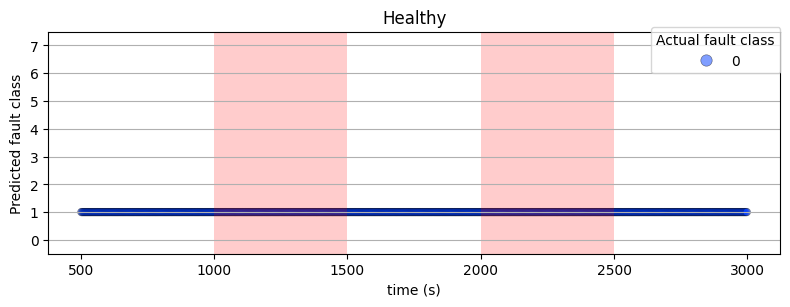

Introduced fault is I & W
20/20 [==============================] - 0s 7ms/step


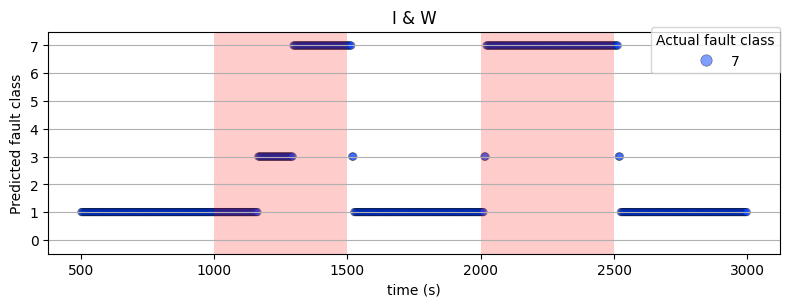

Introduced fault is I
20/20 [==============================] - 0s 9ms/step


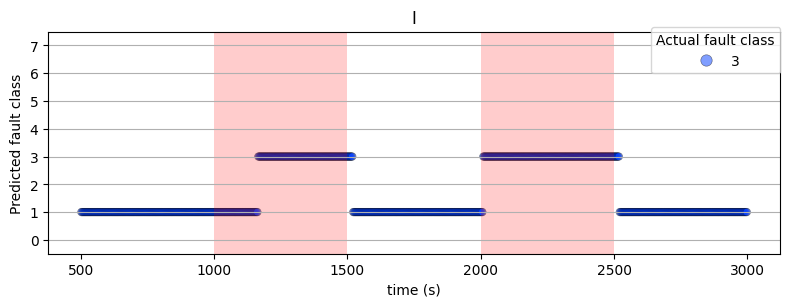

Introduced fault is K
20/20 [==============================] - 0s 8ms/step


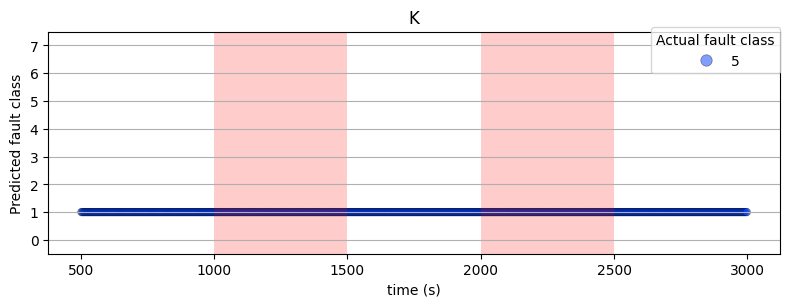

Introduced fault is Re & Rm
20/20 [==============================] - 0s 7ms/step


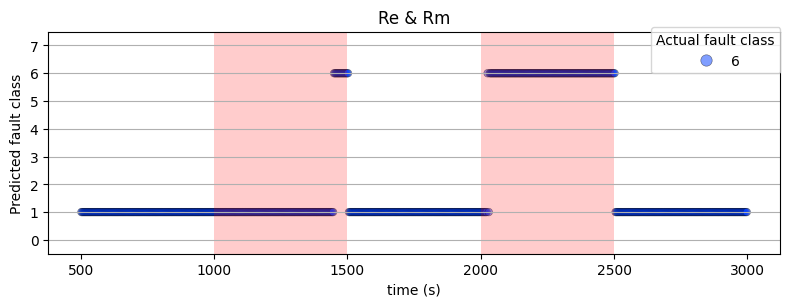

Introduced fault is Re
20/20 [==============================] - 0s 13ms/step


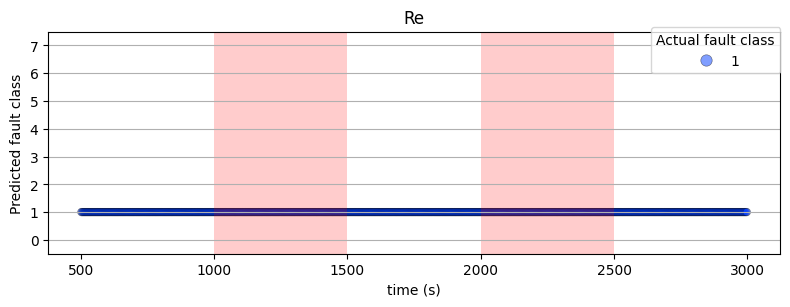

Introduced fault is Rm
20/20 [==============================] - 0s 13ms/step


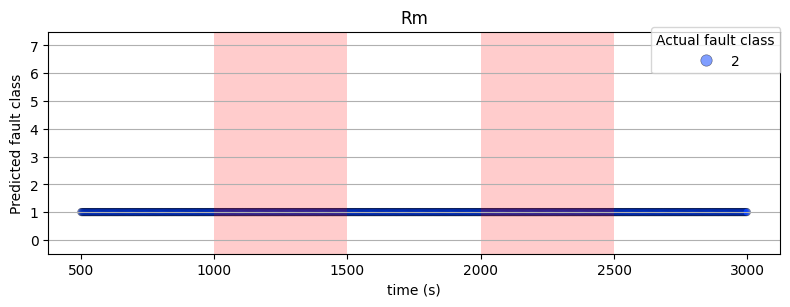

Introduced fault is W
20/20 [==============================] - 0s 13ms/step


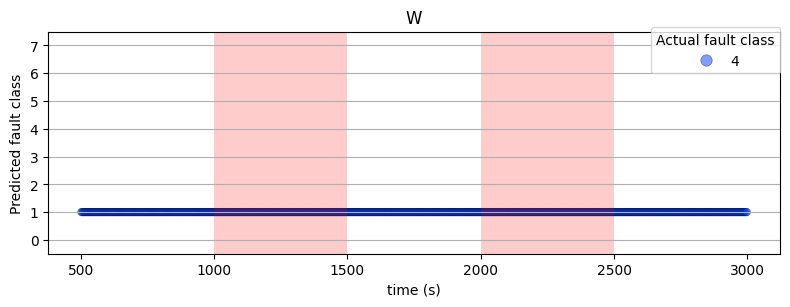

In [43]:
file_name = [
            'Healthy_noise_02.csv',
            'I & W_noise_02.csv',
            'I_noise_02.csv',
            'K_noise_02.csv',
            'Re & Rm_noise_02.csv',
            'Re_noise_02.csv',
            'Rm_noise_02.csv',
            'W_noise_02.csv'
            ]

for f in file_name:
    # Extract the fault type from the file name
    fault_type = f[:-13]

    print(f"Introduced fault is {fault_type}")

    # Perform fault diagnosis using the CNN model
    y_pred_num, y_true_num, t1 = Predict_CNN(fault_file=f, working_cond=40, cnn_model=cnn_model, scaler=scaler, encoder=encoder, WL=WL, S=S)

    # Plot online fault detection and isolation results
    plot_online_FDI(y_pred_num, y_true_num, t1,Title=fault_type)

In [44]:
len(y_pred_num)

625

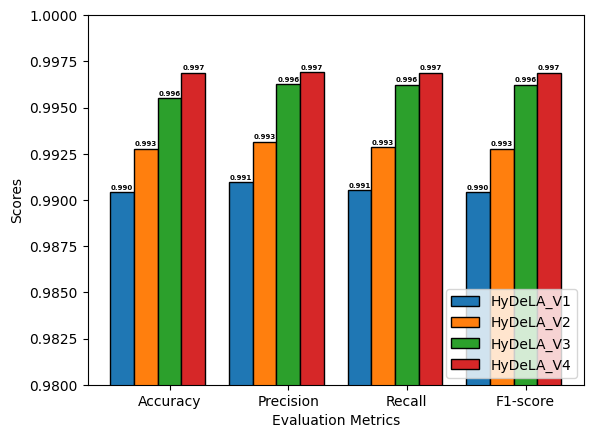

In [45]:
import matplotlib.pyplot as plt
import numpy as np

# Data for plotting
metrics = ['Accuracy', 'Precision', 'Recall', 'F1-score']
HyDeLA_V1 = [0.9904296875, 0.9909474438519507, 0.9905290354865421, 0.9904296875]
HyDeLA_V2 = [0.9927734375, 0.9931388698220402, 0.992848195438128, 0.9927734375]
HyDeLA_V3 = [0.9955078125, 0.9962501925915113, 0.9962288096707737, 0.9962292609351433]
HyDeLA_V4 = [0.996875, 0.996896813610429, 0.9968784699814683, 0.996875]

# Set the width of the bars
width = 0.20

# Create subplots
fig, ax = plt.subplots()

# Plot the bars with black edges
ax.bar(np.arange(len(metrics)) - 2 * width, HyDeLA_V1, width, label='HyDeLA_V1', edgecolor='black')
ax.bar(np.arange(len(metrics)) - width, HyDeLA_V2, width, label='HyDeLA_V2', edgecolor='black')
ax.bar(np.arange(len(metrics)), HyDeLA_V3, width, label='HyDeLA_V3', edgecolor='black')
ax.bar(np.arange(len(metrics)) + width, HyDeLA_V4, width, label='HyDeLA_V4', edgecolor='black')

# Set x-axis labels and title
ax.set_xticks(np.arange(len(metrics)))
ax.set_xticklabels(metrics)
ax.set_xlabel('Evaluation Metrics')
ax.set_ylabel('Scores')
# ax.set_title('Model Performance Comparison')

# Add values on top of the bars with adjusted font size
for i in range(len(metrics)):
    ax.text(i - 2 * width, HyDeLA_V1[i] + 0.0001, f'{HyDeLA_V1[i]:.3f}', ha='center', va='bottom', fontsize=5, weight = 'bold')
    ax.text(i - width, HyDeLA_V2[i] + 0.0001, f'{HyDeLA_V2[i]:.3f}', ha='center', va='bottom', fontsize=5, weight = 'bold')
    ax.text(i, HyDeLA_V3[i] + 0.0001, f'{HyDeLA_V3[i]:.3f}', ha='center', va='bottom', fontsize=5, weight = 'bold')
    ax.text(i + width, HyDeLA_V4[i] + 0.0001, f'{HyDeLA_V4[i]:.3f}', ha='center', va='bottom', fontsize=5, weight = 'bold')

plt.ylim([0.980, 1.00])
# Add a legend
ax.legend(loc='lower right')

# Show the plot
plt.show()


In [46]:
# pip install keras_tuner

In [47]:
# import pandas as pd
# import numpy as np
# import matplotlib.pyplot as plt
# import seaborn as sns
# import os

# from sklearn.preprocessing import OneHotEncoder
# from sklearn.model_selection import train_test_split
# from sklearn.preprocessing import StandardScaler
# from sklearn.metrics import f1_score

# import tensorflow
# from tensorflow import keras
# import keras_tuner as kt


# from sklearn.svm import SVC
# from sklearn.ensemble import RandomForestClassifier
# from sklearn.neighbors import KNeighborsClassifier
# from sklearn.neural_network import MLPClassifier

# def Sliding_Window(df_temp, win_len, stride):
#     """
#     Sliding window function for data segmentation and label extraction.

#     Args:
#         df_temp (DataFrame): Input dataframe containing the data.
#         win_len (int): Length of the sliding window.
#         stride (int): Stride or step size for sliding the window.

#     Returns:
#         X (ndarray): Segmented input sequences.
#         Y (ndarray): Extracted output labels.
#         T (ndarray): Corresponding timestamps.
#     """
#     X = []  # List to store segmented input sequences.
#     Y = []  # List to store extracted output labels.
#     T = []  # List to store corresponding timestamps.

#     # Loop through the dataframe with the specified stride.
#     for i in np.arange(0, len(df_temp) - win_len, stride):
#         # Extract a subset of the dataframe based on the window length.
#         temp = df_temp.iloc[i:i + win_len, [1, 2]].values # Sensor data {Im, Wm}

#         # Append the segmented input sequence to the X list.
#         X.append(temp)

#         # Append the output label at the end of the window to the Y list.
#         Y.append(df_temp.iloc[i + win_len, -1])

#         # Append the timestamp at the end of the window to the T list.
#         T.append(df_temp.iloc[i + win_len, 0])

#     return np.array(X), np.array(Y), np.array(T)

# def PreprocessData(working_cond, win_len, stride):
#     """
#     Preprocessing function to extract input sequences and output labels from CSV files of a specific working condition.

#     Args:
#         working_cond (str): Working condition identifier used to locate the folder containing CSV files.
#         win_len (int): Length of the sliding window.
#         stride (int): Stride or step size for sliding the window.

#     Returns:
#         X_full (ndarray): Concatenated segmented input sequences.
#         Y_full (ndarray): Concatenated output labels.
#     """
#     Path = r'/content/drive/MyDrive/ALL_DC_motor_Data/Ua_{}V_Noise_2_perct'.format(working_cond)  # Path of the folder containing CSV files from that working condition
#     file_name = os.listdir(path=Path)

#     X_full, Y_full = [], []  # Lists to store concatenated segmented input sequences and output labels

#     for f in file_name:  # Iterate through each file, which corresponds to a fault
#         csv_path = os.path.join(Path, f)
#         df = pd.read_csv(csv_path)

#         temp_df_1 = df[(df.time > 1050) & (df.time < 1500)]  # Incipient - Taking samples after which the parameter fault was introduced
#         x1, y1, _ = Sliding_Window(temp_df_1, win_len, stride)

#         temp_df_2 = df[(df.time > 2050) & (df.time < 2500)]  # Step - Taking samples after which the parameter fault was introduced
#         x2, y2, _ = Sliding_Window(temp_df_2, win_len, stride)

#         x_temp, y_temp = np.concatenate((x1, x2), axis=0), np.concatenate((y1, y2), axis=0)

#         X_full.append(x_temp)
#         Y_full.append(y_temp)

#     X_full = np.array(X_full)
#     X_full = np.reshape(X_full, (-1, X_full.shape[2], X_full.shape[3]))

#     Y_full = np.array(Y_full)
#     Y_full = np.reshape(Y_full, (-1))

#     return X_full, Y_full

# WL=20
# S=40

# # Preprocess data for working condition 120
# X_120, Y_120 = PreprocessData(working_cond=120, win_len=WL, stride=S)

# # Preprocess data for working condition 80
# X_80, Y_80 = PreprocessData(working_cond=80, win_len=WL, stride=S)

# # Preprocess data for working condition 40
# X_40, Y_40 = PreprocessData(working_cond=40, win_len=WL, stride=S)

# # Concatenate the preprocessed data from different working conditions
# X_full = np.concatenate((X_40, X_80, X_120))
# Y_full = np.concatenate((Y_40, Y_80, Y_120))

# # Print the length of the total data
# print(f"Length of total data = {len(X_full)}")

# # Dictionary mapping fault labels to numerical values
# fault_label_dict = {'Healthy': 0, 'Re': 1, 'Rm': 2, 'I': 3, 'W': 4, 'K': 5, 'Re & Rm': 6, 'I & W': 7}

# # Convert fault labels in Y_full to corresponding numerical values using the fault_label_dict
# Y_full = np.vectorize(fault_label_dict.get)(Y_full)

# def n_samples_per_class(X_sc,Y,num_samples):
#     """
#     Function to sample a specified number of data points per class.

#     Args:
#         X_sc (ndarray): Input data array.
#         Y (ndarray): Label array.
#         num_samples (int): Number of samples to be selected per class.

#     Returns:
#         x_sample (ndarray): Sampled input data.
#         y_sample (ndarray): Sampled labels.
#     """
#     from sklearn.utils import resample

#     if len(X_sc.shape)==3:
#         # Initialize empty arrays for the sampled data
#         x_sample = np.zeros((num_samples * np.unique(Y).size, X_sc.shape[1], X_sc.shape[2]))
#     else:
#         x_sample = np.zeros((num_samples * np.unique(Y).size, X_sc.shape[1]))
#     y_sample = np.zeros(num_samples * np.unique(Y).size)

#     # Loop over each class label and sample from the corresponding data points
#     for i, label in enumerate(np.unique(Y)):
#         class_indices = np.where(Y == label)[0]
#         sampled_indices = resample(class_indices, n_samples=num_samples, replace=False, random_state=0)
#         x_sample[i*num_samples:(i+1)*num_samples] = X_sc[sampled_indices]
#         y_sample[i*num_samples:(i+1)*num_samples] = Y[sampled_indices]

#     return x_sample,y_sample

# def Scale_Encode(X_full,Y_full, num_training_samples):
#     # Train Test split
#     X_train,y_train=n_samples_per_class(X_full,Y_full,num_samples=num_training_samples)
#     X_test,y_test = X_full, Y_full

#     # Standardising the data
#     scaler = StandardScaler()
#     X_train_sc = scaler.fit_transform(X_train.reshape(-1,X_train.shape[-1])).reshape(X_train.shape)
#     X_test_sc = scaler.transform(X_test.reshape(-1,X_test.shape[-1])).reshape(X_test.shape)
#     # One Hot encoding
#     encoder = OneHotEncoder(sparse_output=False)
#     y_train_ohe = encoder.fit_transform(y_train.reshape(-1,1))
#     y_test_ohe = encoder.transform(y_test.reshape(-1,1))

#     return X_train_sc, X_test_sc, y_train_ohe, y_test_ohe, scaler, encoder

# f1_RF = []  # List to store F1 scores for Random Forest classifier
# f1_KNN = []  # List to store F1 scores for K-Nearest Neighbors classifier
# f1_SVM = []  # List to store F1 scores for Support Vector Machine classifier
# f1_ANN = []  # List to store F1 scores for Artificial Neural Network classifier

# # Iterate over different values of N
# for N in [256]:
#     print(f'Experiment for N = {N}')

#     # Scale, encode, and split the data
#     X_train_sc, X_test_sc, y_train_ohe, y_test_ohe, scaler, encoder = Scale_Encode(X_full, Y_full, num_training_samples=N)
#     X_train_sc, X_test_sc = X_train_sc.reshape(X_train_sc.shape[0], -1), X_test_sc.reshape(X_test_sc.shape[0], -1)
#     y_train, y_test = encoder.inverse_transform(y_train_ohe), encoder.inverse_transform(y_test_ohe)

#     # Support Vector Machine (SVM)
#     svc = SVC().fit(X_train_sc, y_train.ravel())
#     y_pred_svc = svc.predict(X_test_sc)
#     f1_SVM.append(f1_score(y_test, y_pred_svc, average='micro'))

#     # K-Nearest Neighbors (KNN)
#     KNC = KNeighborsClassifier().fit(X_train_sc, y_train.ravel())
#     y_pred_knc = KNC.predict(X_test_sc)
#     f1_KNN.append(f1_score(y_test, y_pred_knc, average='micro'))

#     # Random Forest (RF)
#     RF = RandomForestClassifier().fit(X_train_sc, y_train.ravel())
#     y_pred_rf = RF.predict(X_test_sc)
#     f1_RF.append(f1_score(y_test, y_pred_rf, average='micro'))

#     # Artificial Neural Network (ANN)
#     ANN = MLPClassifier(max_iter=900).fit(X_train_sc, y_train.ravel())
#     y_pred_ann = ANN.predict(X_test_sc)
#     f1_ANN.append(f1_score(y_test, y_pred_ann, average='micro'))

# f1_CNN = []  # List to store F1 scores for CNN with raw sensor signals

# # Iterate over different values of N
# for N in [256]:
#     print(f'CNN - raw sensor Experiment for N = {N}')

#     # Scale, encode, and split the data
#     X_train_sc, X_test_sc, y_train_ohe, y_test_ohe, scaler, encoder = Scale_Encode(X_full, Y_full, num_training_samples=N)

#     # Create and train the CNN model
#     cnn_model = CNN_model(encoder, X_train_sc)
#     callback = tensorflow.keras.callbacks.EarlyStopping(monitor='accuracy', patience=10, restore_best_weights=True)
#     cnn_model.fit(X_train_sc,
#                   y_train_ohe,
#                   epochs=200,
#                   batch_size=int(0.1 * len(X_train_sc)),
#                   callbacks=[callback],
#                   shuffle=True, verbose=0)

#     # Make predictions and calculate F1 score
#     y_pred = cnn_model.predict(X_test_sc)
#     y_pred = encoder.inverse_transform(y_pred)
#     y_test = encoder.inverse_transform(y_test_ohe)

#     f1_CNN.append(f1_score(y_test, y_pred, average='micro'))


# sit = [1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0]

# test_roc = []
# for i in range(len(y_test)):
#   if y_test[i] in sit:
#     test_roc.append(1)
#   else:
#     test_roc.append(0)

# pred_svc_roc = []
# for i in range(len(y_test)):
#   if y_pred_svc[i] in sit:
#     pred_svc_roc.append(1)
#   else:
#     pred_svc_roc.append(0)

# pred_knc_roc = []
# for i in range(len(y_test)):
#   if y_pred_svc[i] in sit:
#     pred_knc_roc.append(1)
#   else:
#     pred_knc_roc.append(0)

# pred_rf_roc = []
# for i in range(len(y_test)):
#   if y_pred_svc[i] in sit:
#     pred_rf_roc.append(1)
#   else:
#     pred_rf_roc.append(0)

# pred_ann_roc = []
# for i in range(len(y_test)):
#   if y_pred_svc[i] in sit:
#     pred_ann_roc.append(1)
#   else:
#     pred_ann_roc.append(0)

# pred_cnn_roc = []
# for i in range(len(y_test)):
#   if y_pred[i] in sit:
#     pred_cnn_roc.append(1)
#   else:
#     pred_cnn_roc.append(0)

# from sklearn.metrics import roc_curve, roc_auc_score, auc

# # Example: Actual and predicted values (replace with your own data)
# fpr_svc, tpr_svc, threshold_svc = roc_curve(test_roc, pred_svc_roc)
# fpr_knc, tpr_knc, threshold_knc = roc_curve(test_roc, pred_knc_roc)
# fpr_rf, tpr_rf, threshold_rf = roc_curve(test_roc, pred_rf_roc)
# fpr_ann, tpr_ann, threshold_ann = roc_curve(test_roc, pred_ann_roc)
# fpr_cnn, tpr_cnn, threshold_cnn = roc_curve(test_roc, pred_cnn_roc)

# roc_svc_auc = auc(fpr_svc, tpr_svc)
# roc_knc_auc = auc(fpr_knc, tpr_knc)
# roc_rf_auc = auc(fpr_rf, tpr_rf)
# roc_ann_auc = auc(fpr_ann, tpr_ann)
# roc_cnn_auc = auc(fpr_cnn, tpr_cnn)


# plt.figure(figsize=(8, 6))

# plt.plot(fpr, tpr, color='red', lw=2, label=f"HyDeLA (AUC = {roc_auc:.2f})")
# plt.plot(fpr_svc, tpr_svc, color='blue', lw=2, label=f"SVM (AUC = {roc_svc_auc:.2f})")
# plt.plot(fpr_knc, tpr_knc, color='green', lw=2, label=f"KNN (AUC = {roc_knc_auc:.2f})")
# plt.plot(fpr_rf, tpr_rf, color='cyan', lw=2, label=f"RF (AUC = {roc_rf_auc:.2f})")
# plt.plot(fpr_ann, tpr_ann, color='black', lw=2, label=f"ANN (AUC = {roc_ann_auc:.2f})")
# plt.plot(fpr_cnn, tpr_cnn, color='purple', lw=2, label=f"CNN (AUC = {roc_cnn_auc:.2f})")



# plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
# plt.xlim([0.0, 1.0])
# plt.ylim([0.0, 1.05])
# plt.xlabel('False Positive Rate (FPR)')
# plt.ylabel('True Positive Rate (TPR)')
# plt.title('Receiver Operating Characteristic (ROC) Curve')
# plt.legend(loc="lower right")
# plt.show()


In [48]:
# plt.figure(figsize=(8, 6))
# plt.plot(fpr, tpr, color='red', lw=2, label=f"HyDeLA (AUC = {roc_auc:.2f})")
# plt.plot(fpr_svc, tpr_svc, color='blue', lw=2, label=f"SVM (AUC = {roc_svc_auc:.2f})")
# plt.plot(fpr_knc, tpr_knc, color='green', lw=2, label=f"KNN (AUC = {roc_knc_auc:.2f})")
# plt.plot(fpr_rf, tpr_rf, color='cyan', lw=2, label=f"RF (AUC = {roc_rf_auc:.2f})")
# plt.plot(fpr_ann, tpr_ann, color='black', lw=2, label=f"ANN (AUC = {roc_ann_auc:.2f})")
# plt.plot(fpr_cnn, tpr_cnn, color='purple', lw=2, label=f"CNN (AUC = {roc_cnn_auc:.2f})")
# plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
# plt.xlim([0.0, 1.0])
# plt.ylim([0.0, 1.05])
# plt.xlabel('False Positive Rate (FPR)')
# plt.ylabel('True Positive Rate (TPR)')
# plt.title('Receiver Operating Characteristic (ROC) Curve')
# plt.legend(loc="lower right")
# plt.show()

In [49]:
# plt.figure(figsize=(8, 6))
# plt.plot(fpr, tpr, color='red', lw=2, label=f"HyDeLA (AUC = {roc_auc:.2f})")
# plt.plot(fpr_svc, tpr_svc, color='blue', lw=2, label=f"SVM (AUC = {roc_svc_auc:.2f})")
# plt.plot(fpr_knc, tpr_knc, color='green', lw=2, label=f"KNN (AUC = {roc_knc_auc:.2f})")
# plt.plot(fpr_rf, tpr_rf, color='cyan', lw=2, label=f"RF (AUC = {roc_rf_auc:.2f})")
# plt.plot(fpr_ann, tpr_ann, color='black', lw=2, label=f"ANN (AUC = {roc_ann_auc:.2f})")
# plt.plot(fpr_cnn, tpr_cnn, color='purple', lw=2, label=f"CNN (AUC = {roc_cnn_auc:.2f})")
# plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
# plt.xlim([0.0, 1.0])
# plt.ylim([0.0, 1.05])
# plt.xlabel('False Positive Rate (FPR)')
# plt.ylabel('True Positive Rate (TPR)')
# plt.title('Receiver Operating Characteristic (ROC) Curve')
# plt.legend(loc="lower right")
# plt.show()

In [50]:
# def CNN_model(encoder,X_train_transformed):
#     from tensorflow.keras.models import Sequential,Model
#     from tensorflow.keras.layers import Input,Dense, Dropout, Flatten
#     from tensorflow.keras.layers import Conv1D, MaxPooling1D

#     # Hyperparameters obtained aftre tuning
#     num_k1=112
#     k1 = 5
#     num_d1=96
#     alpha = 0.001

#     num_classes=len(encoder.categories_[0])

#     cnn_model = Sequential()
#     cnn_model.add(Conv1D(num_k1, kernel_size=(k1),activation='relu',input_shape=(X_train_transformed.shape[1],X_train_transformed.shape[2]),padding='same'))
#     cnn_model.add(MaxPooling1D((2),padding='same'))
#     cnn_model.add(Flatten())
#     cnn_model.add(Dense(num_d1, activation='relu'))
#     cnn_model.add(Dense(num_classes, activation='softmax'))

#     cnn_model.compile(loss='categorical_crossentropy', optimizer=tensorflow.keras.optimizers.Adam(learning_rate=alpha),metrics=['accuracy'])

#     return cnn_model

# y_pred_bg = cnn_model.predict(X_test_sc)
# y_pred_bg = encoder.inverse_transform(y_pred_bg)

# pred_bg_roc = []
# for i in range(len(y_test)):
#   if y_pred_bg[i] in sit:
#     pred_bg_roc.append(1)
#   else:
#     pred_bg_roc.append(0)

# fpr_bg, tpr_bg, threshold_bg = roc_curve(test_roc, pred_bg_roc)
# roc_bg_auc = auc(fpr_bg, tpr_bg)

In [51]:
# plt.figure(figsize=(8, 6))
# plt.plot(fpr, tpr, color='red', lw=2, label=f"HyDeLA (AUC = {roc_auc:.2f})")
# plt.plot(fpr_bg, tpr_bg, color='yellow', lw=2, label=f"BG-CNN (AUC = {roc_auc:.2f})")
# plt.plot(fpr_svc, tpr_svc, color='blue', lw=2, label=f"SVM (AUC = {roc_svc_auc:.2f})")
# plt.plot(fpr_knc, tpr_knc, color='green', lw=2, label=f"KNN (AUC = {roc_knc_auc:.2f})")
# plt.plot(fpr_rf, tpr_rf, color='cyan', lw=2, label=f"RF (AUC = {roc_rf_auc:.2f})")
# plt.plot(fpr_ann, tpr_ann, color='black', lw=2, label=f"ANN (AUC = {roc_ann_auc:.2f})")
# plt.plot(fpr_cnn, tpr_cnn, color='purple', lw=2, label=f"CNN (AUC = {roc_cnn_auc:.2f})")
# plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
# plt.xlim([0.0, 1.0])
# plt.ylim([0.0, 1.05])
# plt.xlabel('False Positive Rate (FPR)')
# plt.ylabel('True Positive Rate (TPR)')
# plt.title('Receiver Operating Characteristic (ROC) Curve')
# plt.legend(loc="lower right")
# plt.show()

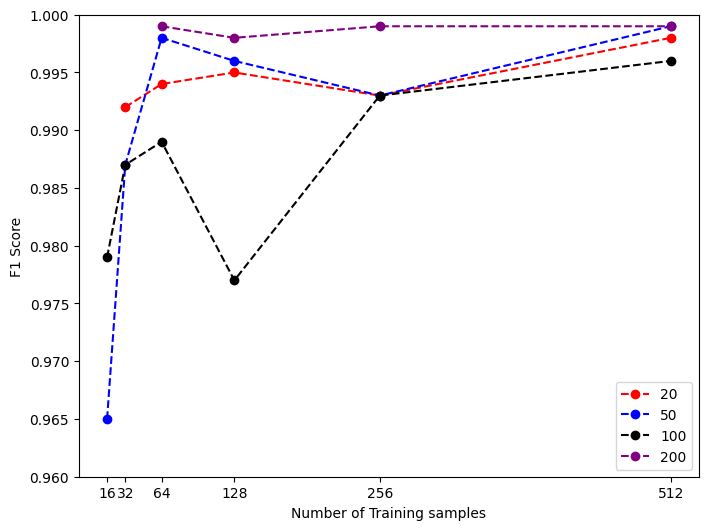

In [52]:
plt.figure(figsize=(8, 6))
r20 = [0.992, 0.994, 0.995, 0.993, 0.998]
r50 = [0.965, 0.987, 0.998, 0.996, 0.993, 0.999]
r100 = [0.979, 0.987, 0.989, 0.977, 0.993, 0.996]
r200 = [0.999, 0.998, 0.999, 0.999]

x1 = [16,32,64,128,256,512]
x2 = [32,64,128,256,512]
x3 = [64,128,256,512]

r200_interpolated = np.interp(r200, x3, r200)
r20_interpolated = np.interp(r20, x2, r20)



plt.plot(x2,r20,color='red',marker='o', linewidth=1.5, markersize=6, label = '20', linestyle = 'dashed')
plt.plot(x1,r50,color='blue',marker='o', linewidth=1.5, markersize=6, label = '50', linestyle = 'dashed')
plt.plot(x1,r100,color='black',marker='o', linewidth=1.5, markersize=6, label = '100', linestyle = 'dashed')
plt.plot(x3,r200,color='purple',marker='o', linewidth=1.5, markersize=6, label = '200', linestyle = 'dashed')
# plt.plot([str(x) for x in [16,32,64,128,256,512]],r20,color='red',marker='o', linewidth=1.5, markersize=6, label = '20', linestyle = 'dashed')
# plt.plot([str(x) for x in [16,32,64,128,256,512]],r50,color='blue',marker='o', linewidth=1.5, markersize=6, label = '50', linestyle = 'dashed')
# plt.plot([str(x) for x in [16,32,64,128,256,512]],r100,color='black',marker='o', linewidth=1.5, markersize=6, label = '100', linestyle = 'dashed')
# plt.plot([str(x) for x in [16,32,64,128,256,512]],r200,color='purple',marker='o', linewidth=1.5, markersize=6, label = '200', linestyle = 'dashed')
plt.ylim([0.960,1.000])
plt.xticks([16, 32, 64, 128, 256, 512])
# plt.grid(visible=True)
plt.legend(['20','50', '100', '200'], loc = 'lower right')
plt.xlabel('Number of Training samples')
plt.ylabel('F1 Score')
plt.show()

In [53]:
# import matplotlib.pyplot as plt

# # Create a new figure
# plt.figure(figsize=(8, 6))

# # Plot each ROC curve separately
# plt.plot(fpr, tpr, color='red', lw=2, label=f"HyDeLA (AUC = {roc_auc:.2f})")
# plt.plot(fpr_bg, tpr_bg, color='yellow', lw=2, label=f"BG-CNN (AUC = {roc_bg_auc:.2f})", linestyle='--')
# plt.plot(fpr_svc, tpr_svc, color='blue', lw=2, label=f"SVM (AUC = {roc_svc_auc:.2f})", linestyle='--')
# plt.plot(fpr_knc, tpr_knc, color='green', lw=2.5, label=f"KNN (AUC = {roc_knc_auc:.2f})", linestyle='-.')
# plt.plot(fpr_rf, tpr_rf, color='cyan', lw=2, label=f"RF (AUC = {roc_rf_auc:.2f})", linestyle=':')
# plt.plot(fpr_ann, tpr_ann, color='black', lw=1.5, label=f"ANN (AUC = {roc_ann_auc:.2f})", linestyle='dashdot')
# plt.plot(fpr_cnn, tpr_cnn, color='purple', lw=2, label=f"CNN (AUC = {roc_cnn_auc:.2f})", linestyle=':')

# # Add the diagonal line
# plt.plot([0, 1], [0, 1], color='gray', linestyle='--')

# # Set plot limits and labels
# plt.xlim([-0.05, 1.05])
# plt.ylim([-0.05, 1.05])
# plt.xlabel('False Positive Rate (FPR)')
# plt.ylabel('True Positive Rate (TPR)')
# plt.title('Receiver Operating Characteristic (ROC) Curve')
# plt.legend(loc="lower right")

# # Show the plot
# plt.show()
